In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from IPython.display import display, HTML

/!\ Attention : il est nécessaire d'installer 'xlrd'

On installe par : pip install xlrd

# Chargement des Données

## A partir du fichier xlsx

In [3]:
def load_from_xlsx():
    df1 = pd.read_excel('Online Retail.xlsx')
    #df1.to_csv('online_retail.csv', index=False)
    return df1

df1 = load_from_xlsx()

df1.shape
# (541909, 8)

(541909, 8)

## Données vides 

In [4]:
np.sum(df1.isnull(), axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

> On remarque que les données de Descriptions sont vides pour quelques données

> Par contre il manque une grosse partie des informations sur les ID de CUSTOMERS à hauteur de 25 % 

## Description vide

In [5]:
df1[df1.Description.isnull()].describe()

,Quantity,UnitPrice,CustomerID
count,1454.000000,1454.0,0.0
mean,-9.359697,0.0,NaN
std,243.238758,0.0,NaN
min,-3667.000000,0.0,NaN
25%,-24.000000,0.0,NaN
50%,-3.000000,0.0,NaN
75%,4.000000,0.0,NaN
max,5568.000000,0.0,NaN


> Les descriptions vides le sont pour des données ayant des Prix Unitaires nulles et sans id d'utilisateurs

> Ce sont des données que nous ne pouvons utiliser : nous allons supprimer ce lignes

In [6]:
df1.drop(labels=df1[df1.Description.isnull()].index, inplace=True)

## CustomerID

In [7]:
np.sum(df1.isnull(), axis=0)

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

In [8]:
df1[df1.CustomerID.isnull()].describe()

,Quantity,UnitPrice,CustomerID
count,133626.000000,133626.000000,0.0
mean,2.119131,8.164459,NaN
std,62.064626,152.722663,NaN
min,-9600.000000,-11062.060000,NaN
25%,1.000000,1.630000,NaN
50%,1.000000,3.290000,NaN
75%,3.000000,5.790000,NaN
max,4000.000000,17836.460000,NaN


In [9]:
df1.drop(labels=df1[df1.CustomerID.isnull()].index, inplace=True)

In [10]:
df1.shape

(406829, 8)

## Pays des clients

In [11]:
df2 = df1.groupby(['CustomerID', 'Country']).size().reset_index(name='Freq')
df3 = df2.groupby(['CustomerID']).size().reset_index(name='Freq2')
df3 = df3[df3.Freq2>1]
print("Liste des clients ayant plusieurs pays d'affectation\n") 
display(pd.merge(left=df2, right=df3, on=['CustomerID'])[['CustomerID', 'Country', 'Freq']])

Liste des clients ayant plusieurs pays d'affectation



,CustomerID,Country,Freq
0,12370.0,Austria,8
1,12370.0,Cyprus,159
2,12394.0,Belgium,21
3,12394.0,Denmark,6
4,12417.0,Belgium,175
5,12417.0,Spain,23
6,12422.0,Australia,21
7,12422.0,Switzerland,18
8,12429.0,Austria,21
9,12429.0,Denmark,76


## Description des Articles

In [12]:
df2 = df1.groupby(['StockCode', 'Description']).size().reset_index(name='Freq')
df3 = df2.groupby(['StockCode']).size().reset_index(name='Freq2')
df3 = df3[df3.Freq2>1]

In [13]:
df3.Freq2.unique(), df3.shape

(array([2, 3, 4]), (213, 2))

> Nous avons 213 articles ayant plusieurs descriptions
>
> Nous n'allons garder que la description la plus représentée

In [14]:
# Nous identifions les doublons de descriptions
df2 = df1.groupby(['StockCode', 'Description']).size().reset_index(name='Freq')
df3 = df2.groupby(['StockCode']).size().reset_index(name='Freq2')
df4 = pd.merge(left=df2, right=df3, on=['StockCode'])
df4 = df4.sort_values(by=['StockCode', 'Freq'])[['StockCode', 'Description']]

# Nous supprimons les doublons de descriptions les moins représentés
df4 = df4.drop_duplicates(subset=['StockCode'], keep='first')

# Nous supprimons les anciennes descriptions
df1.drop(labels=['Description'], axis=1, inplace=True)

# Nous appliquons à chaque StockCode une unique description
df1 = pd.merge(left=df1, right=df4, on=['StockCode'])

# Ajout de Features

## Les Numéros de Factures

> Il est dit que les numéros de factures sont numériques sauf pour les annulations de factures
> (qui commencent par un 'C')

> Nous allons séparer les numéros de factures par une feature booléenne : isInvoiceNo_numeric

In [15]:
import re 

def is_numeric(value):
    '''Renvoie un binaire pour dire si une valeure est numérique ou non'''
    m = re.search('^([0-9]*)$', value)
    if m==None:
        return False
    else:
        return True
    

df1['isInvoiceNo_numeric'] = df1.InvoiceNo.apply(lambda x: is_numeric(str(x)))

In [16]:
display(df1.groupby(['isInvoiceNo_numeric']).size())

isInvoiceNo_numeric
False      8905
True     397924
dtype: int64

## Le prix des achats
> Nous avons le prix unitaire et la quantité, nous pouvons calculer le prix de chaque commande d'articles

In [17]:
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']

> On regarde la répartition des prix négatifs par rapport aux autres

In [18]:
df1['isNeg_TotalPrice'] = df1['TotalPrice'].apply(lambda x: np.sign(x))
df1.groupby(['isNeg_TotalPrice', 'isInvoiceNo_numeric']).size().reset_index(name='Freq')

,isNeg_TotalPrice,isInvoiceNo_numeric,Freq
0,-1.0,False,8905
1,0.0,True,40
2,1.0,True,397884


> Nous allons supprimer les commandes ayant un prix nul : ce sont celles ayant un prix unitaire nul

In [19]:
df1.drop(labels=df1[df1.UnitPrice==0].index, inplace=True)

> Nous pouvons supprimer notre feature temporaire : isNeg_TotalPrice

In [20]:
df1.drop(labels=['isNeg_TotalPrice'], axis=1, inplace=True)

## Duplicas 

> Il n'est pas possible d'identifier des duplicas car dans les mêmes factures on trouve des lignes de commandes en double plutôt que d'avoir un nombre différents du nombre d'articles
>
> ex: 

In [21]:
df1[(df1.InvoiceNo==536381) & (df1.StockCode==71270)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice
39410,536381,71270,1,2010-12-01 09:41:00,1.25,15311.0,United Kingdom,PHOTO CLIP LINE,True,1.25
39411,536381,71270,3,2010-12-01 09:41:00,1.25,15311.0,United Kingdom,PHOTO CLIP LINE,True,3.75


## Articles les plus achetés

In [22]:
df2 = df1.groupby(['StockCode', 'Quantity']).size().reset_index(name='Freq')
df2.head()

,StockCode,Quantity,Freq
0,10002,1,7
1,10002,2,4
2,10002,3,1
3,10002,4,3
4,10002,5,2


In [23]:
df2 = df1[df1.isInvoiceNo_numeric==True].groupby(['StockCode', 'Quantity']).size().reset_index(name='Freq')


df2['Nb'] = df2.Quantity*df2.Freq
df3 = df2.groupby(['StockCode']).agg('sum')

# Les articles les plus commandés
df3.sort_values('Nb', ascending=False).head()

,Quantity,Freq,Nb
StockCode,,,
23843,80995,1,80995
23166,75129,198,77916
84077,17580,473,54415
22197,16721,1068,49183
85099B,4587,1618,46181


In [24]:
# Quantité total des articles 
np.sum(df1[df1.isInvoiceNo_numeric==True]['Quantity']), np.sum(df1['Quantity'])

(5167812, 4893004)

In [25]:
df1[df1.StockCode==23843].head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice
406827,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",True,168469.6
406828,C581484,23843,-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",False,-168469.6


In [26]:
df1[df1.StockCode==23166].head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice
319141,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,True,77183.60
319142,C541433,23166,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,False,-77183.60
319143,552882,23166,96,2011-05-12 10:10:00,1.04,14646.0,Netherlands,MEDIUM CERAMIC TOP STORAGE JAR,True,99.84
319144,552953,23166,4,2011-05-12 12:11:00,1.25,16745.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,True,5.00
319145,553005,23166,5,2011-05-12 16:29:00,1.25,14651.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,True,6.25


# Données Aberrantes

## TotalPrice
> On commence par un boxplot

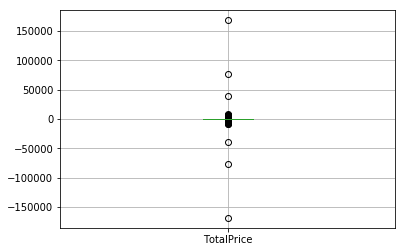

In [27]:
df1.boxplot(column=['TotalPrice'])

> On remarque des Outliers au dessus de 10 000 ou inférieur à -10 000

In [28]:
df1[(df1.TotalPrice>10000) | (df1.TotalPrice<-10000)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice
70870,556444,22502,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,PICNIC BASKET WICKER 60 PIECES,True,38970.0
198142,C556445,M,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,Manual,False,-38970.0
319141,541431,23166,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,True,77183.6
319142,C541433,23166,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,MEDIUM CERAMIC TOP STORAGE JAR,False,-77183.6
406827,581483,23843,80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",True,168469.6
406828,C581484,23843,-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,"PAPER CRAFT , LITTLE BIRDIE",False,-168469.6


> Ces transactions sont des transactions que se retrouvent annulées, elles semblent bien au desssus de la 'Norme' 
>
> Nous allons supprimer ces 3 transactions, et leurs annulations

In [29]:
df1.drop(labels=df1[(df1.TotalPrice>10000) | (df1.TotalPrice<-10000)].index, inplace=True)

## UnitPrice

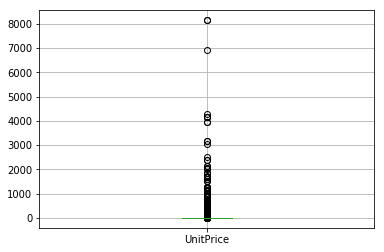

In [30]:
df1.boxplot(column=['UnitPrice'])

> Des données sortent du lot pour un prix unitaire supérieur à 2000 

In [31]:
df2 = df1[df1.UnitPrice>2000].copy()
df2.loc[:, 'TotalPrice2'] = np.abs(df2.TotalPrice)
df2.sort_values(by=['TotalPrice2'], ascending=False)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice,TotalPrice2
198331,C573079,M,-2,2011-10-27 14:15:00,4161.06,12536.0,France,Manual,False,-8322.12,8322.12
18853,C551685,POST,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,POSTAGE,False,-8142.75,8142.75
18854,551697,POST,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,POSTAGE,True,8142.75,8142.75
198105,C551699,M,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,Manual,False,-6930.00,6930.00
198183,C560372,M,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,Manual,False,-4287.63,4287.63
198330,573077,M,1,2011-10-27 14:13:00,4161.06,12536.0,France,Manual,True,4161.06,4161.06
198332,573080,M,1,2011-10-27 14:20:00,4161.06,12536.0,France,Manual,True,4161.06,4161.06
198307,C571750,M,-1,2011-10-19 11:16:00,3949.32,12744.0,Singapore,Manual,False,-3949.32,3949.32
198309,571751,M,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore,Manual,True,3949.32,3949.32
198219,C562647,M,-1,2011-08-08 12:56:00,3155.95,15502.0,United Kingdom,Manual,False,-3155.95,3155.95


> On remarque que les prix unitaires sont les plus importants pour les stockecode 'M' / 'D' / 'DOT' / 'CRUK' 

> On va voir le nombre de valeurs en jeu : nous allons ajouter à cela le code POST

> Ces informations sont des articles qui semblent gérés manuellemenent, ou sont des tarifs d'affranchissement ou de commission : ce ne sont pas des achats directs

In [32]:
df1[(df1.StockCode=='M') | (df1.StockCode=='D') | (df1.StockCode=='DOT') | 
    (df1.StockCode=='CRUK') | (df1.StockCode=='POST')].shape

(1763, 10)

> Ces données représentent une proportion faible de nos données 
> 
> Nous allons les supprimer

In [33]:
df1.drop(labels=df1[(df1.StockCode=='M') | (df1.StockCode=='D') | (df1.StockCode=='DOT') | 
    (df1.StockCode=='CRUK') | (df1.StockCode=='POST')].index, inplace=True)

> Ces données nettoyées nous pouvons reprendre le boxplot

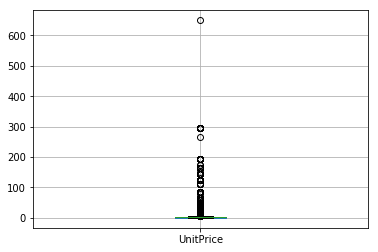

In [34]:
df1.boxplot(column=['UnitPrice'])

In [35]:
df1[df1.UnitPrice>200]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description,isInvoiceNo_numeric,TotalPrice
70871,556446,22502,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,PICNIC BASKET WICKER 60 PIECES,True,649.5
251650,536835,22655,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,VINTAGE RED KITCHEN CABINET,True,295.0
251655,539080,22655,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,VINTAGE RED KITCHEN CABINET,True,295.0
251656,C539438,22655,-1,2010-12-17 15:11:00,295.0,16607.0,United Kingdom,VINTAGE RED KITCHEN CABINET,False,-295.0
251658,540647,22655,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,VINTAGE RED KITCHEN CABINET,True,295.0
251659,C540652,22655,-1,2011-01-10 15:04:00,265.5,17406.0,United Kingdom,VINTAGE RED KITCHEN CABINET,False,-265.5
251668,543253,22655,1,2011-02-04 15:32:00,295.0,14842.0,United Kingdom,VINTAGE RED KITCHEN CABINET,True,295.0
251670,C543632,22655,-1,2011-02-10 16:22:00,295.0,14842.0,United Kingdom,VINTAGE RED KITCHEN CABINET,False,-295.0
251683,554836,22655,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom,VINTAGE RED KITCHEN CABINET,True,295.0
306136,546480,22656,1,2011-03-14 11:38:00,295.0,13452.0,United Kingdom,VINTAGE BLUE KITCHEN CABINET,True,295.0


> On voit ici que cela ne concerne que 2 articles dont un qui est souvent annulé

> Supprimer ces 2 articles ne biaisera pas nos analyse : nous allons le faire mais avant nous allons faire les boxplot en limitant à plusieurs valeurs

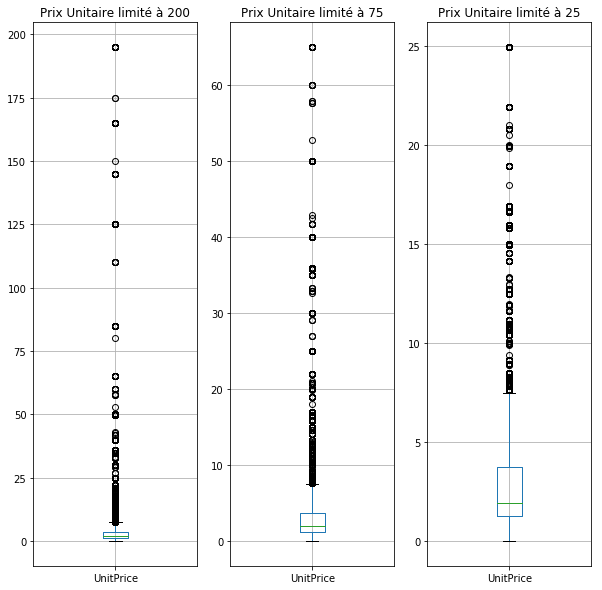

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(131)
df1[df1.UnitPrice<200].boxplot(column=['UnitPrice'])
plt.title('Prix Unitaire limité à 200')

plt.subplot(132)
df1[df1.UnitPrice<75].boxplot(column=['UnitPrice'])
plt.title('Prix Unitaire limité à 75')

plt.subplot(133)
df1[df1.UnitPrice<25].boxplot(column=['UnitPrice'])
plt.title('Prix Unitaire limité à 25')

plt.show()

In [37]:
sum(df1.UnitPrice>200), sum(df1.UnitPrice>75), sum(df1.UnitPrice>25),\
    sum(df1.UnitPrice>45), len(df1)

(12, 165, 643, 348, 405020)

> En supprimant les données ayant un prix unitaire supérieur à 45 nous allons supprimer moins de 0.1 % des données (0.086 %)

> Nous allons donc les supprimer

In [38]:
df1.drop(labels=df1[df1.UnitPrice>45].index, inplace=True)

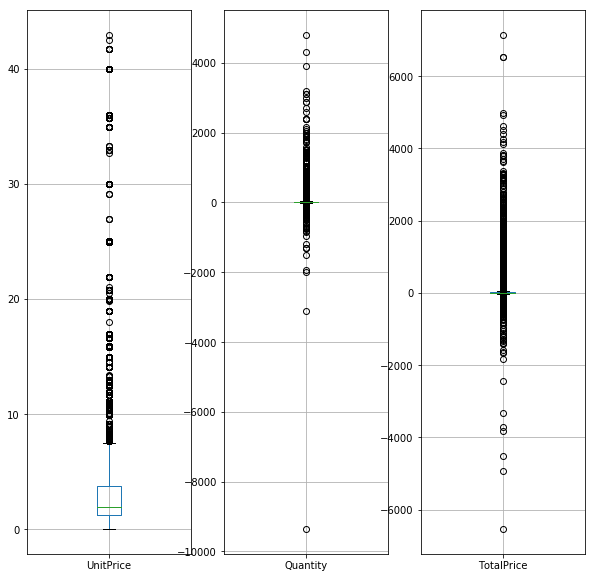

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(131)
df1.boxplot(column=['UnitPrice'])
#plt.title('Prix Unitaire limité à 200')

plt.subplot(132)
df1.boxplot(column=['Quantity'])

plt.subplot(133)
df1.boxplot(column=['TotalPrice'])

plt.show()

> Il reste quelques suppressions manuelles

In [40]:
df1.drop(labels=df1[df1.Quantity<-2000].index, inplace=True)
df1.drop(labels=df1[df1.Quantity>3500].index, inplace=True)

df1.drop(labels=df1[df1.TotalPrice>6000].index, inplace=True)
df1.drop(labels=df1[df1.TotalPrice<-2000].index, inplace=True)

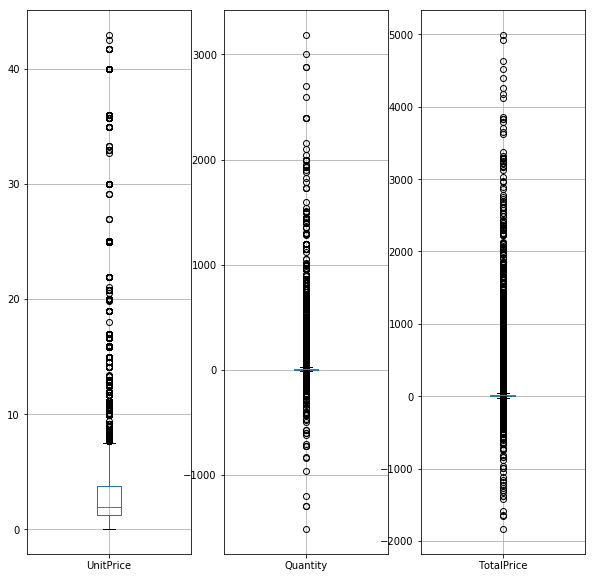

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(131)
df1.boxplot(column=['UnitPrice'])
#plt.title('Prix Unitaire limité à 200')

plt.subplot(132)
df1.boxplot(column=['Quantity'])

plt.subplot(133)
df1.boxplot(column=['TotalPrice'])

plt.show()

## Clients n'ayant pas de factures positives
> On s'aperçoit que des clients n'ont plus que des factures négatives
> 
> Nous allons les supprimer : car c'est un comportement annormal
> (il s'agit de 28 clients, pour 89 transactions)

In [42]:
# On Compte le nombre de Facture positives
df2 = df1.groupby(['CustomerID']).agg(
    {'isInvoiceNo_numeric': [('Nb_Facture_Positive', lambda x: (x==True).sum())]})
df2.columns = df2.columns.droplevel(level=0)

# On ne conserve que la liste des clients n'ayant pas de facture positives
df2 = df2[df2.Nb_Facture_Positive==0]

print("Nous avons {} clients qui n'ont que des factures négatives".format(len(df2)))

Nous avons 28 clients qui n'ont que des factures négatives


> Nous allons supprimer les transactions de ces clients qui ne nous apportent aucune information

In [43]:
# On dresse la liste des id des clients
l_clients_sans_facture_positive = df2.index.tolist()

# On ajoute une colonne des clients à supprimer
df1['Client_sans_Facture_Positive'] = \
    df1.CustomerID.apply(lambda x: True if x in l_clients_sans_facture_positive else False)

In [44]:
# On supprime les transactions des clients n'ayant que des factures négatives
df1.drop(labels=df1[df1.Client_sans_Facture_Positive].index, inplace=True)

In [45]:
# Il reste à supprimer la colonne ajoutée temporairement
df1.drop(labels=['Client_sans_Facture_Positive'], axis=1, inplace=True)

# Annulation des factures
> Il peut être intéressant de visualiser le lien entre les commandes et les annulations qui ont pu eu lieu

In [46]:
from mes_fonctions import ajoute_lien_annulation_produit
df1 = ajoute_lien_annulation_produit(df1)

1 / 3933
1001 / 3933
2001 / 3933
3001 / 3933


In [47]:
df1.groupby(['isInvoiceNo_numeric','isCanceled' ]).size().reset_index(name='Freq')

,isInvoiceNo_numeric,isCanceled,Freq
0,False,False,5694
1,False,True,2714
2,True,False,393447
3,True,True,2714


- Nous avons 8497 commandes d'annulation, soit 2.1 % des transactions
- 2 714 ont été liées avec leur commande ( 0.67 % des transactions)

In [48]:
print("Nous avons {} factures ".format(df1.InvoiceNo.nunique()))
print("Nous avons {} articles différents ".format(df1.StockCode.nunique()))
print("Nous avons {} clients différents (ayant des ID) ".format(df1.CustomerID.nunique()))
print("Le CA est de : {:.2f} (après suppression des commandes annulées)"
      .format(df1.TotalPrice.sum()))
print("La somme totale de l'annulation est de : {:.2f} "
      .format(df1[df1.isInvoiceNo_numeric==False].TotalPrice.sum()))

Nous avons 21704 factures 
Nous avons 3669 articles différents 
Nous avons 4328 clients différents (ayant des ID) 
Le CA est de : 8225920.26 (après suppression des commandes annulées)
La somme totale de l'annulation est de : -191518.35 


# EXPLORATION

### Description rapide

In [49]:
df1.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,404569.000000,404569.000000,404569.000000,404569.000000
mean,12.081464,2.836015,15295.116620,20.332552
std,40.792847,2.919208,1710.466639,68.155344
min,-1515.000000,0.001000,12347.000000,-1836.000000
25%,2.000000,1.250000,13969.000000,4.200000
50%,5.000000,1.950000,15159.000000,10.900000
75%,12.000000,3.750000,16794.000000,19.500000
max,3186.000000,42.950000,18287.000000,4992.000000


## Les dates

In [50]:
df1.InvoiceDate.min(), df1.InvoiceDate.max(), 

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

> Les données sont comprises entre le 1e décembre 2010 et le 9 décembre 2011

## Les Pays

In [51]:
df1.Country.value_counts()

United Kingdom          360952
Germany                   9092
France                    8169
EIRE                      7375
Spain                     2466
Netherlands               2322
Belgium                   1971
Switzerland               1843
Portugal                  1436
Australia                 1254
Norway                    1058
Italy                      783
Channel Islands            753
Finland                    653
Cyprus                     612
Sweden                     437
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
USA                        291
Israel                     246
Unspecified                244
Singapore                  213
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon                     45
Lithuani

> Les transactions concernent en hyper majorité des clients du Royaume Uni (89 % des transactions)

# Feature Engineering 
> Nous allons réorganiser les données pour faire une synthèse par client

Les features ajoutées sont les suivantes:
- Recency : nombre de jours de différence entre le dernier jour du DataSet et la derniere commande passée
- Freq_Invoice : nombre de commandes passées (qui peuvent être des annulations)
- Somme_Invoice : somme totale des achats et annulations pour le client
- Mean_Invoice_Price : prix moyen des commandes
- Mean_Article_Price : prix moyen des articles commandés
- Nb_Article_Total : nombre total d'articles 
    - on tient compte des quantités de chaque article
    - les annulations font baisser le nombre total 
- Mean_Invoice_Price_Canceled : prix moyen des factures d'annulations 
    - ne tient compte que des valeurs négatives
- FI_Price: Montant de la 1e commande (ne prend pas en compte les annulations comme 1e commande)
- FI_Article_Nb : Quantité d'articles total de la 1e commande
- FI_Mean_Article_Price : Prix moyen des articles de la 1e commande

In [52]:
import mes_fonctions as stt
clients = stt.defined_new_features_V2(data=df1)

In [53]:
clients.head().T

CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0
Recency,1.000000,74.000000,18.000000,309.000000,35.000000
Freq_Invoice,7.000000,4.000000,1.000000,1.000000,8.000000
Somme_Invoice,4310.000000,1437.240000,1457.550000,294.400000,1265.410000
Mean_Invoice_Price,615.714286,359.310000,1457.550000,294.400000,158.176250
Mean_Article_Price,1.753458,0.616312,2.313571,1.502041,2.733067
Nb_Article_Total,2458.000000,2332.000000,630.000000,196.000000,463.000000
Mean_Invoice_Price_Canceled,0.000000,0.000000,0.000000,0.000000,-15.041250
FI_Price,711.790000,652.800000,1457.550000,294.400000,296.500000
FI_Article_Nb,319.000000,1248.000000,630.000000,196.000000,98.000000
FI_Mean_Article_Price,2.231317,0.523077,2.313571,1.502041,3.025510


In [54]:
clients.describe()

,Recency,Freq_Invoice,Somme_Invoice,Mean_Invoice_Price,Mean_Article_Price,Nb_Article_Total,Mean_Invoice_Price_Canceled,FI_Price,FI_Article_Nb,FI_Mean_Article_Price
count,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000,4328.000000
mean,89.668438,5.014787,1900.628527,321.944125,2.021850,1129.340573,-5.025458,397.810054,242.098429,2.194075
std,99.328361,9.107212,8258.355884,383.413245,1.363182,4686.591825,35.935779,511.643915,348.123640,1.653019
min,0.000000,1.000000,-796.860000,-398.430000,0.000000,-303.000000,-1764.170000,0.850000,1.000000,0.060000
25%,16.000000,1.000000,295.437500,152.985000,1.382319,157.750000,-2.493750,164.222500,83.000000,1.389031
50%,49.000000,3.000000,648.555000,238.088625,1.769552,372.000000,0.000000,298.080000,156.000000,1.847806
75%,138.000000,5.000000,1603.525000,369.165000,2.294952,971.000000,0.000000,439.102500,281.000000,2.543305
max,373.000000,242.000000,278156.220000,10485.166667,31.616667,196548.000000,0.000000,9639.120000,7824.000000,39.950000


## Clients qui ont une somme totale vide 

In [55]:
clients[clients.Somme_Invoice<1]

,Recency,Freq_Invoice,Somme_Invoice,Mean_Invoice_Price,Mean_Article_Price,Nb_Article_Total,Mean_Invoice_Price_Canceled,FI_Price,FI_Article_Nb,FI_Mean_Article_Price
CustomerID,,,,,,,,,,
12454.0,52,2,0.00,0.000000,0.000000,0,-1764.170000,3528.34,1006,3.507296
12558.0,1,2,0.00,0.000000,0.000000,0,-134.980000,269.96,196,1.377347
12607.0,57,2,0.00,0.000000,0.000000,0,-789.755000,1579.51,1228,1.286246
13364.0,66,2,0.00,0.000000,0.000000,0,-67.480000,134.96,71,1.900845
13672.0,300,5,0.00,0.000000,0.000000,0,-37.278000,62.13,19,3.270000
13762.0,203,2,0.00,0.000000,0.000000,0,-153.360000,306.72,272,1.127647
14557.0,63,2,0.00,0.000000,0.000000,0,-394.190000,788.38,510,1.545843
14792.0,63,2,0.00,0.000000,0.000000,0,-3.100000,6.20,2,3.100000
15098.0,181,2,0.00,0.000000,0.000000,0,-148.500000,297.00,60,4.950000


In [56]:
clients[clients.Somme_Invoice<0]

,Recency,Freq_Invoice,Somme_Invoice,Mean_Invoice_Price,Mean_Article_Price,Nb_Article_Total,Mean_Invoice_Price_Canceled,FI_Price,FI_Article_Nb,FI_Mean_Article_Price
CustomerID,,,,,,,,,,
15823.0,336,2,-796.86,-398.430000,2.835801,-281,-405.930000,15.0,1,15.000000
16546.0,290,3,-95.93,-31.976667,0.316601,-303,-294.360000,299.4,156,1.919231
17548.0,217,3,-141.48,-47.160000,1.071818,-132,-81.593333,103.3,58,1.781034


> Nous pouvons supprimer ces clients car il nous manque des données : il n'est pas possible d'annuler des commandes non passées

In [57]:
clients.drop(labels=clients[clients.Somme_Invoice<0].index, inplace=True)

# Sauvegarde des donnée

In [58]:
df1.to_csv('Data_Filtree_Etape1.csv', index=False)
#df1 = pd.read_csv('Data_Filtree_Etape1.csv')

## Répartition des achats
> Nous allons analyser si nous voyons un PARETO dans la répartition des clients

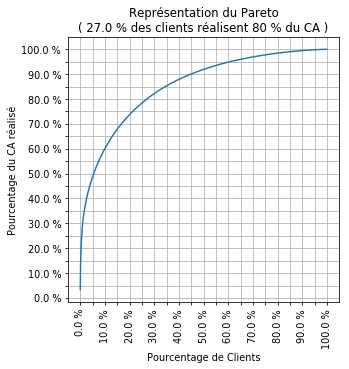

In [59]:
# Nous allons ordonner les clients par prix total des achats
o_Price_rfm = clients.sort_values(by=['Somme_Invoice'], ascending=False)
# Nous les normons
o_Price_rfm['TotalPrice_Normed'] = o_Price_rfm['Somme_Invoice'] / sum(o_Price_rfm.Somme_Invoice)
# Nous faisons la somme cumulée
o_Price_rfm['TotalPrice_CumSum'] = o_Price_rfm['TotalPrice_Normed'].cumsum()*100


# Représentation de l'évolution du CA par nombre de clients
u = np.linspace(0.0, 100.0, num=len(o_Price_rfm), endpoint=False)
plt.figure(figsize=(5,5), dpi=70)
plt.plot(u, o_Price_rfm['TotalPrice_CumSum'])
plt.xlabel('Pourcentage de Clients')
#plt.xticks([x for x in np.linspace(0.0, 100.0,num=21, endpoint=True)])
plt.xticks(np.arange(0, 105, step=5),
           [str(x) + ' %' if x%10==0 else '' for x in np.linspace(0.0, 100.0,num=21, endpoint=True)] ,
          rotation=90)
#np.arange(0, 1, step=0.2)

plt.yticks(np.arange(0, 105, step=5),
           [str(x) + ' %' if x%10==0 else '' for x in np.linspace(0.0, 100.0,num=21, endpoint=True)])
plt.ylabel('Pourcentage du CA réalisé')

pct_80 = np.round(100*sum(o_Price_rfm['TotalPrice_CumSum' ]<80.0)/len(o_Price_rfm),decimals=0)
plt.title('Représentation du Pareto\n( {} % des clients réalisent 80 % du CA )'.format(pct_80))
plt.grid()
plt.show()

# Analyse unidimensionnelle rapide

In [60]:
def represente_repartition(data, col):
    '''
    Fonction qui trace l'histogramme 
    et le boxplot d'une feature donnée
    '''
    #plt.figure(figsize=(15,5))
    plt.figure(figsize=(10,3))
    plt.subplot(121)
    data[col].hist(bins=200)
    plt.subplot(122)
    data.boxplot(column=[col])
    plt.suptitle(col)
    plt.show()
    
    
l_col = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
        'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']

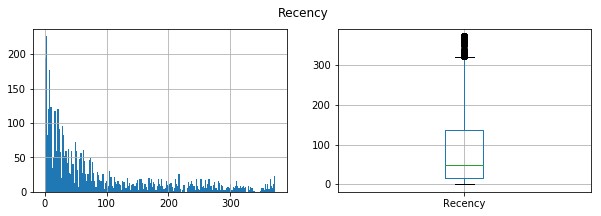

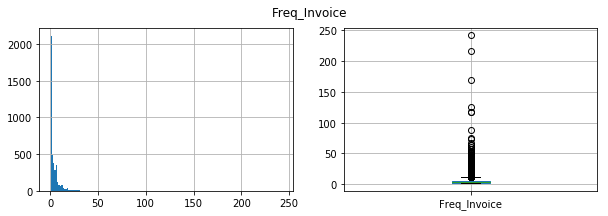

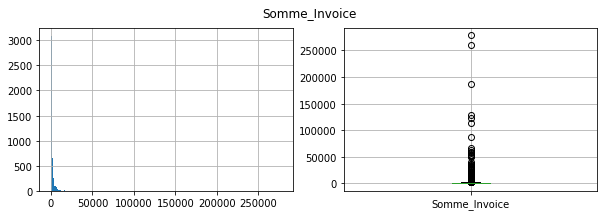

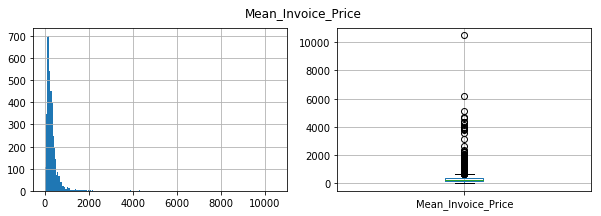

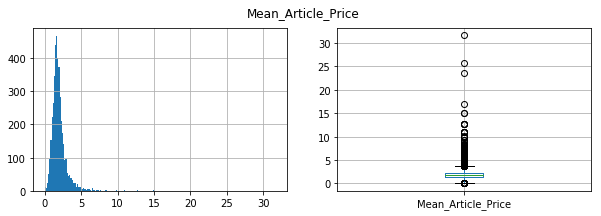

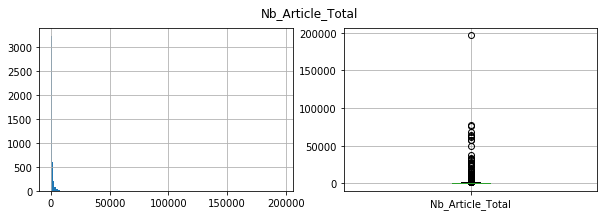

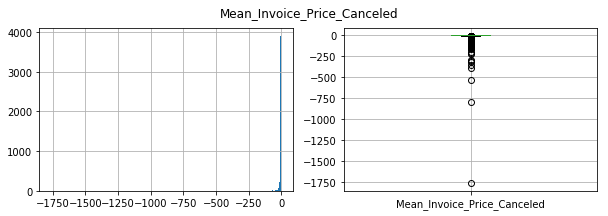

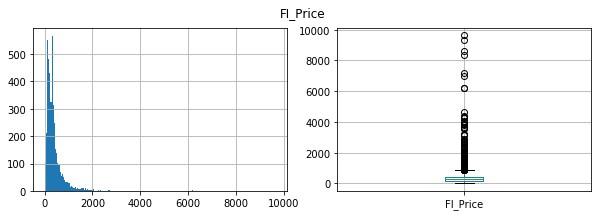

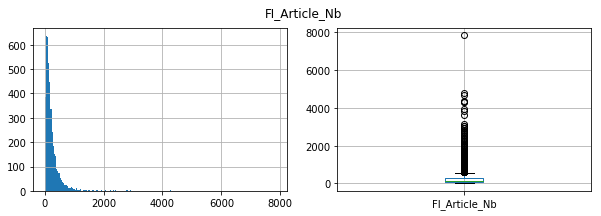

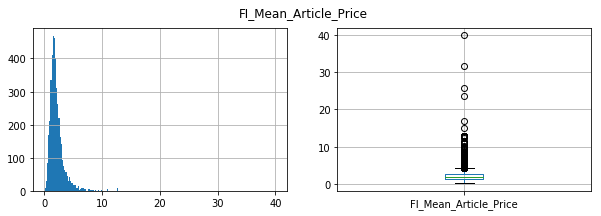

In [61]:
for i in clients.columns.tolist():
    represente_repartition(clients, col=i)

## Outliers
> Des informations pour certains clients sortent du lot
> 
> Nous allons analyser ce que leur mise à l'écart peut provoquer

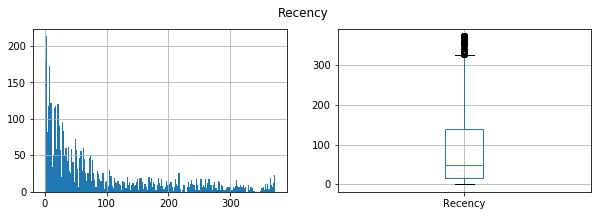

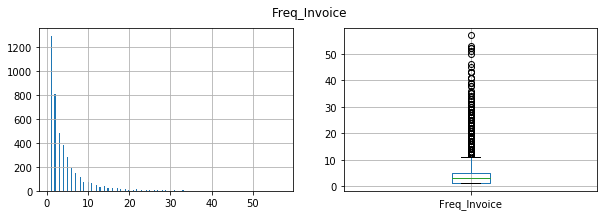

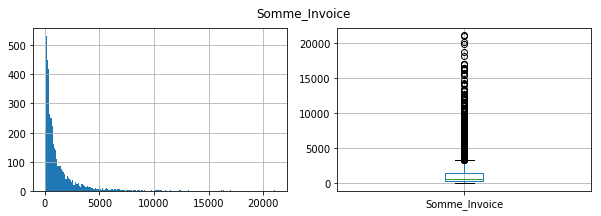

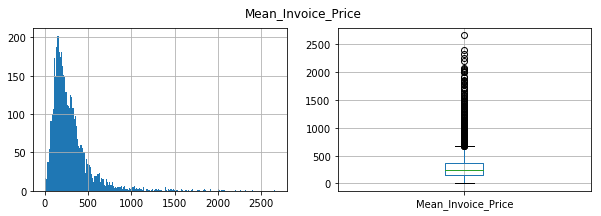

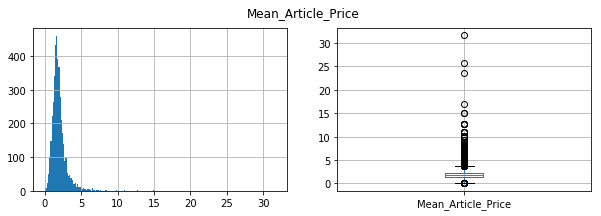

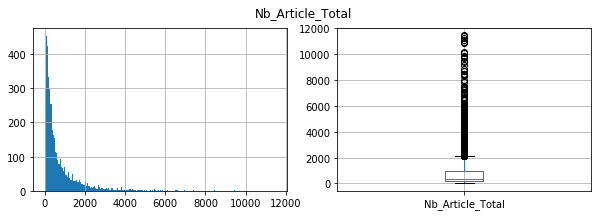

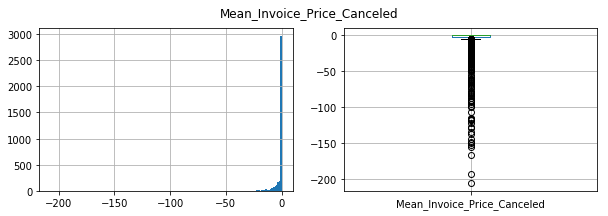

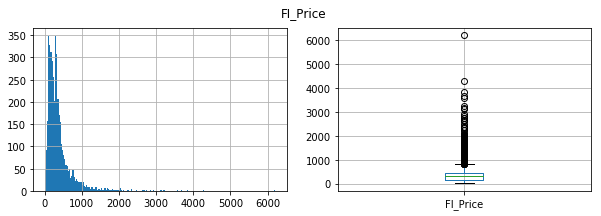

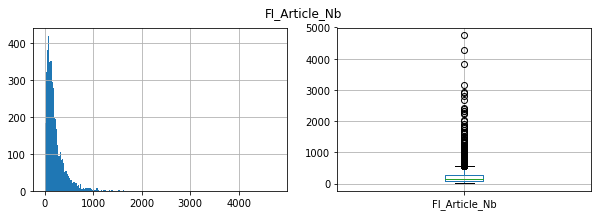

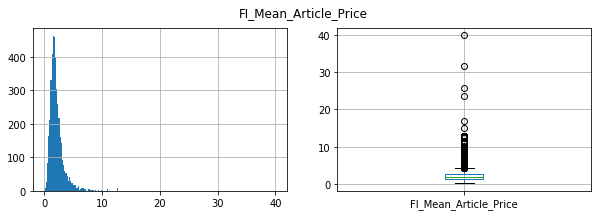

Taux de données à écarter : 1.29 %


In [62]:
l_col = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
        'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']

clients_bis = clients[
    (clients.Mean_Invoice_Price<3000) &
    (clients.Freq_Invoice<60) &
    (clients.Somme_Invoice<25000) &
    (clients.Somme_Invoice<40000) &
    (clients.Mean_Invoice_Price_Canceled>-250) &
    (clients.Nb_Article_Total<12500)
    ]

for i in clients_bis.columns.tolist():
    represente_repartition(clients_bis, col=i)
    
#clients.shape, clients_bis.shape
print('Taux de données à écarter : {:.2f} %'
      .format(  100*(clients.shape[0] - clients_bis.shape[0])/clients.shape[0]))

# Corrélation entre les features
Nous allons mettre en évidence les potentielles corrélations existantes entre les 
différentes features, pour cela nous allons représenter le heatmap de la matrice de corrélations

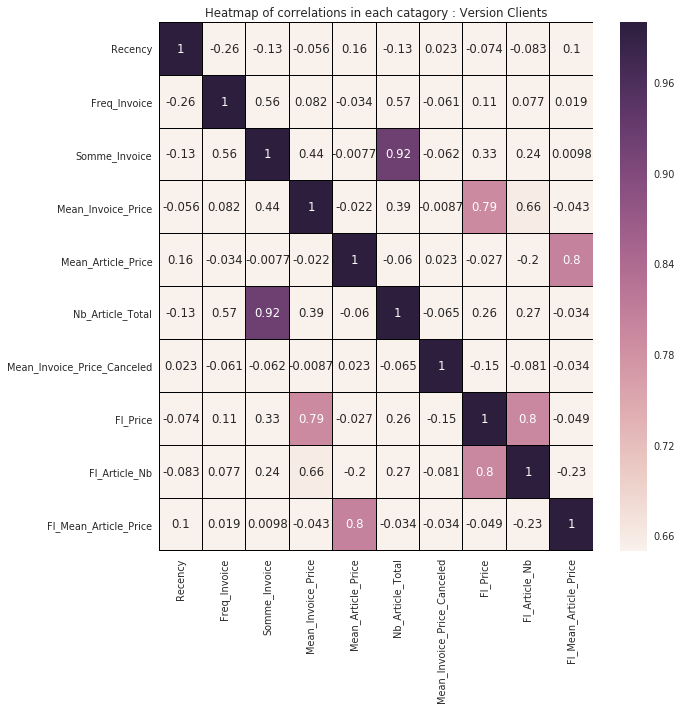

In [63]:
import seaborn as sns

correlations = clients.corr()
plt.figure(figsize = (10,10), dpi=70)
plt.title("Heatmap of correlations in each catagory : Version Clients")
_ = sns.heatmap(correlations, vmin=0.65, vmax=1, annot=True, linewidths=0.01, linecolor='k')
sns.reset_orig()

> Nous constatons que nous avons une corrélation forte entre :
    - Somme_Invoice et la feature Nb_Article_Total
    - Mean_Invoice_Price et FI_Price 
    - Mean_Article_Price et FI_Mean_Article_Price
    - FI_Price et FI_Article_Nb
> Nous nous servirons de ces corrélations pour la modélisation des données générales à partir des données de la 1e commande

## Heatmap des corrélation pour les données filtrées

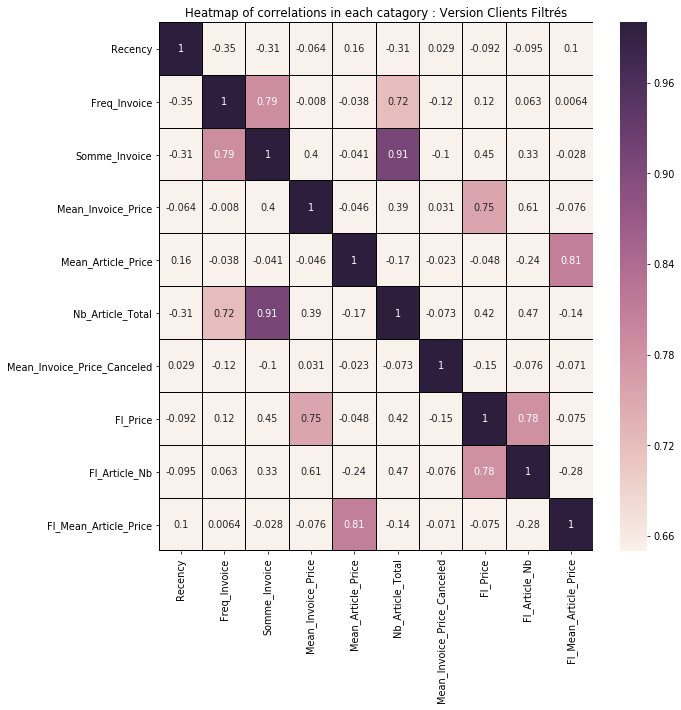

In [64]:
correlations = clients_bis.corr()
plt.figure(figsize = (10,10), dpi=70)
plt.title("Heatmap of correlations in each catagory : Version Clients Filtrés")
_ = sns.heatmap(correlations, vmin=0.65, vmax=1, annot=True, linewidths=0.01, linecolor='k')
sns.reset_orig()

> Nous constatons que nous avons ajouté ici une corrélation relativement forte entre :
    - Freq_Invoice et les features Somme_Invoice et Nb_Article_Total

## Représentation des corrélations
> Nous allons faire cette représentation sous forme de nuages de points pour les différentes paires de features

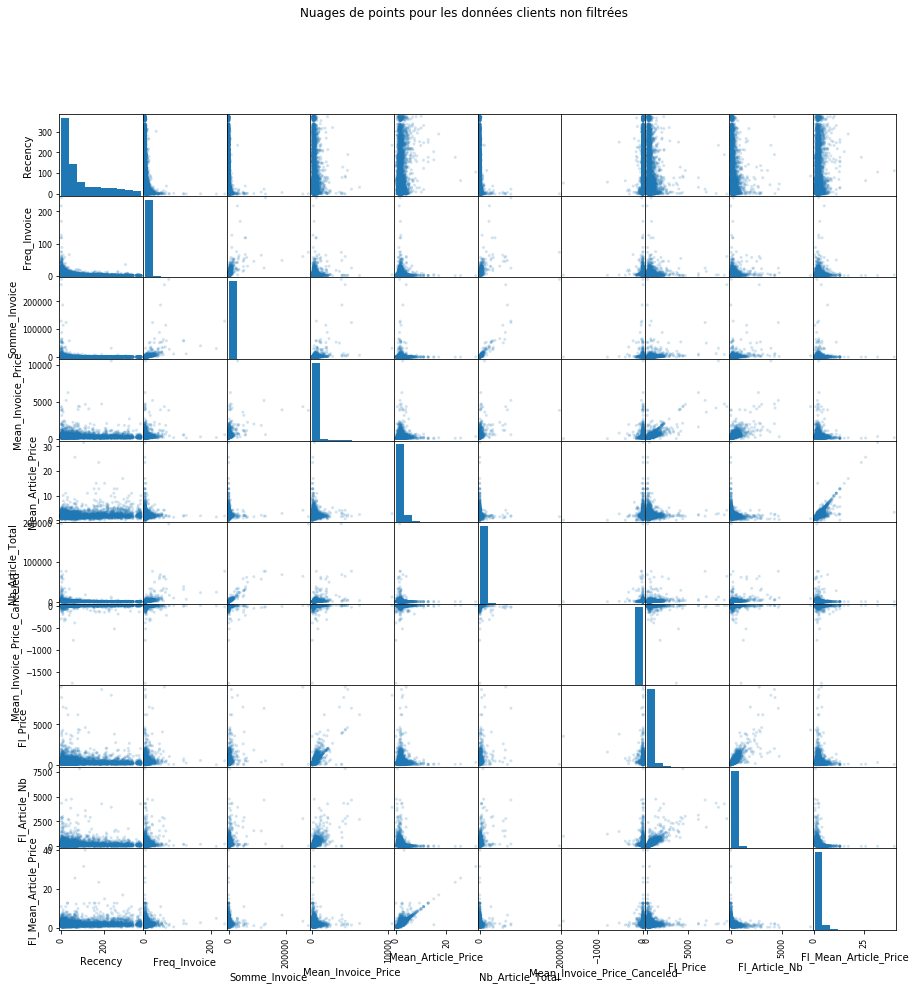

In [65]:
ax = pd.plotting.scatter_matrix(clients, alpha=0.2, figsize=(15,15), )
plt.suptitle('Nuages de points pour les données clients non filtrées')
plt.show()

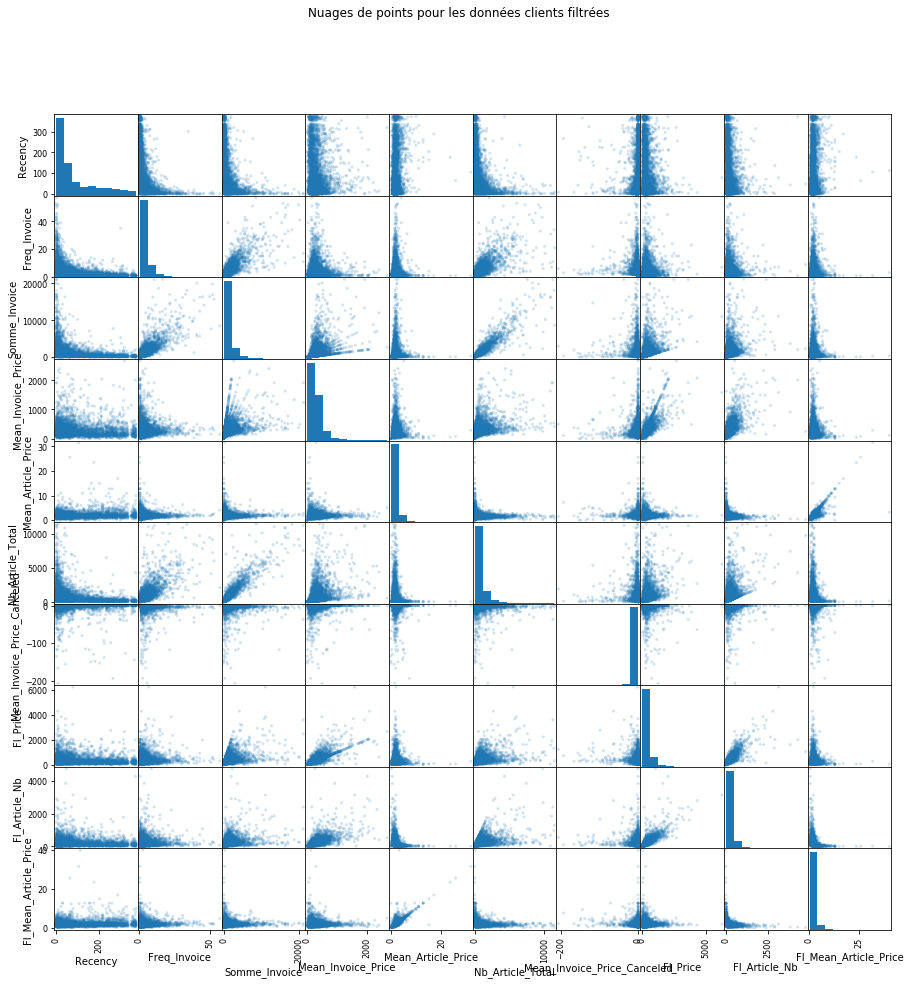

In [66]:
ax = pd.plotting.scatter_matrix(clients_bis, alpha=0.2, figsize=(15,15), )
plt.suptitle('Nuages de points pour les données clients filtrées')
plt.show()

> Ces nuages de points nous permettent de confirmer les résultats des heatmap 

# Clustering
> Nous allons baser nos clusters sur le quartile dans lequel se situent chaque features de nos clients

## Description des Clusters

In [67]:
clients_bis.head()

,Recency,Freq_Invoice,Somme_Invoice,Mean_Invoice_Price,Mean_Article_Price,Nb_Article_Total,Mean_Invoice_Price_Canceled,FI_Price,FI_Article_Nb,FI_Mean_Article_Price
CustomerID,,,,,,,,,,
12347.0,1,7,4310.00,615.714286,1.753458,2458,0.00000,711.79,319,2.231317
12348.0,74,4,1437.24,359.310000,0.616312,2332,0.00000,652.80,1248,0.523077
12349.0,18,1,1457.55,1457.550000,2.313571,630,0.00000,1457.55,630,2.313571
12350.0,309,1,294.40,294.400000,1.502041,196,0.00000,294.40,196,1.502041
12352.0,35,8,1265.41,158.176250,2.733067,463,-15.04125,296.50,98,3.025510


In [68]:
#import mes_fonctions as stt
clients_bis = clients_bis.copy()

clients_bis = stt.ajoute_quantiles(data_train=clients_bis, data_to_apply=clients_bis)
clients_bis = stt.modelisation_cluster_rfm(clients_bis)

In [69]:
clients = clients.copy()

clients = stt.ajoute_quantiles(data_train=clients, data_to_apply=clients)
clients = stt.modelisation_cluster_rfm(clients)

In [70]:
sum(clients.quartile_somme==1)

1081

## Représentation PCA de ces clusters

In [71]:
## Les listes de features
l1 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
       'Mean_Article_Price', 'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       'FI_Price', 'FI_Article_Nb', 'FI_Mean_Article_Price']
l2 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',
       'Mean_Article_Price', 'Nb_Article_Total', 'Mean_Invoice_Price_Canceled',
       ]
l3 = ['Recency', 'Freq_Invoice', 'Somme_Invoice', 'Mean_Invoice_Price',]
l4 = ['Recency', 'Freq_Invoice', 'Mean_Invoice_Price',]

Debut  2018-10-11 18:35:45.539505
Les 2 composantes de PCA représententsur la variance totale : [ 0.45784869  0.71687426]
Fin  2018-10-11 18:35:45.547379  -->  0:00:00.007874


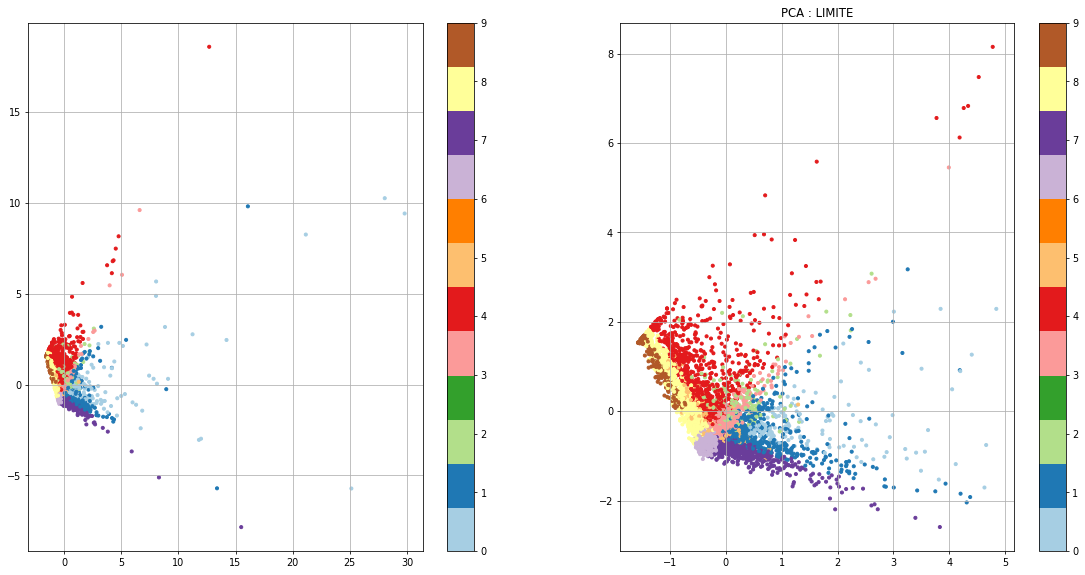

In [72]:
# Avec l'utilisation de 4 features sur le dataset de Clients
stt.visualise_PCA(l_col=l3, col_couleur='couleur', data=clients, x_limit=5)

Debut  2018-10-11 18:35:46.022084
Les 2 composantes de PCA représententsur la variance totale : [ 0.43094397  0.75396431]
Fin  2018-10-11 18:35:46.025723  -->  0:00:00.003639


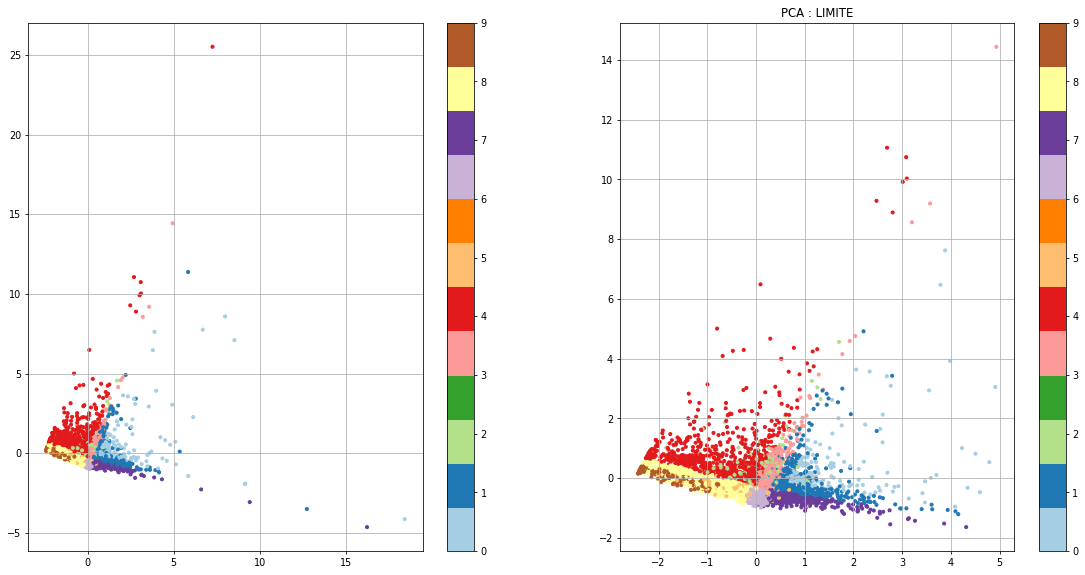

In [73]:
# Avec l'utilisation de 3 features sur le dataset de Clients
stt.visualise_PCA(l_col=l4, col_couleur='couleur', data=clients, x_limit=5)

Debut  2018-10-11 18:35:46.633163
Les 2 composantes de PCA représententsur la variance totale : [ 0.45155224  0.78583452]
Fin  2018-10-11 18:35:46.636074  -->  0:00:00.002911


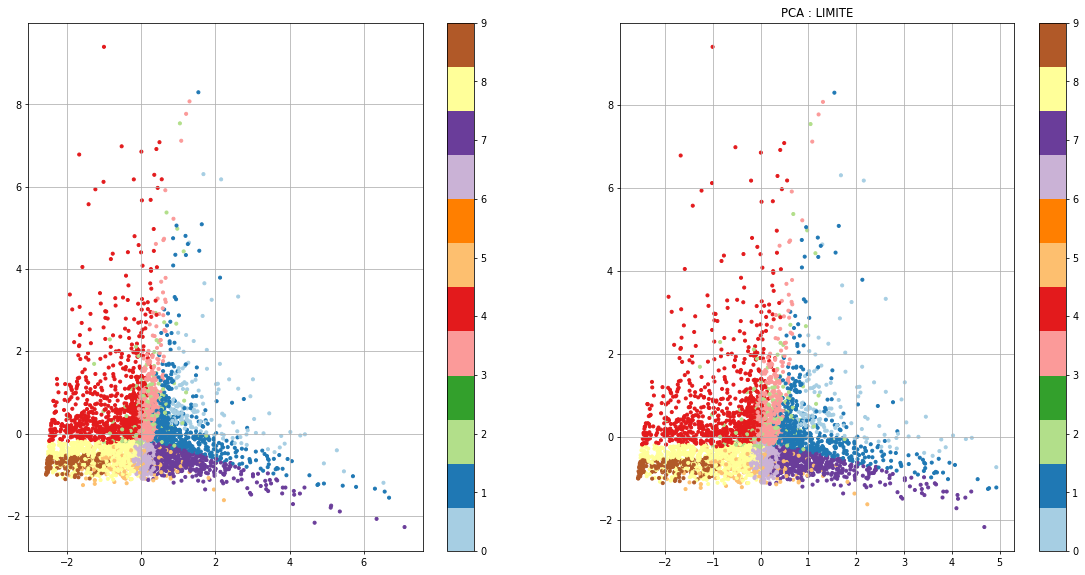

In [74]:
# Avec l'utilisation de 3 features sur le dataset de Clients filtrés
stt.visualise_PCA(l_col=l4, col_couleur='couleur', data=clients_bis, x_limit=5)

In [75]:
# Répartition des clusters en nombre d'individus
clients_bis.couleur.value_counts()

4    807
8    700
7    582
1    543
6    448
3    433
5    208
2    207
9    197
0    144
Name: couleur, dtype: int64

> On constate que la répartition est assez équivalente en nombre

> La réduction en 2 dimensions selon les 3 features 'Recency', 'Freq_Invoice', 'Mean_Invoice_Price' nous donne une réprésentation PCA qui assez bien délimitée
> 
> A noter que les clusters 3, 5 et 6 sont assez proches des autres